In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from collections import Counter

In [2]:
trainImgPath = "/kaggle/input/severstal-steel-defect-detection/train_images/"
trainCsvPath = "/kaggle/input/severstal-steel-defect-detection/train.csv"
train = pd.read_csv(trainCsvPath)

print(train.shape) # 7095 областей с дефектом в трейне

(7095, 3)


In [3]:
train1 = pd.DataFrame()
train1['ImageId_ClassId'] = train['ImageId'] + '_' + train['ClassId'].astype(str)
train1['EncodedPixels'] = train['EncodedPixels']
train1.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
df = pd.DataFrame()
img_id = os.listdir(trainImgPath)
size = len(img_id)

img_id_classid = [img_id[i] + '_' + str(j) for i in range(size) for j in range(1, 4 + 1)]
img_id_classid
df['ImageId_ClassId'] = img_id_classid

print(len(img_id))
df.head()

12568


,ImageId_ClassId
0,de6c85c29.jpg_1
1,de6c85c29.jpg_2
2,de6c85c29.jpg_3
3,de6c85c29.jpg_4
4,985c8ac4f.jpg_1


In [5]:
train1 = df.merge(train1, on = ['ImageId_ClassId'], how='left')
train1.tail(10)

,ImageId_ClassId,EncodedPixels
50262,d58350401.jpg_3,NaN
50263,d58350401.jpg_4,NaN
50264,7ca829ecd.jpg_1,NaN
50265,7ca829ecd.jpg_2,NaN
50266,7ca829ecd.jpg_3,NaN
50267,7ca829ecd.jpg_4,NaN
50268,69df9d97b.jpg_1,11710 13 11954 25 12210 25 12466 25 12722 25 1...
50269,69df9d97b.jpg_2,NaN
50270,69df9d97b.jpg_3,NaN
50271,69df9d97b.jpg_4,NaN


In [6]:
train1.shape

(50272, 2)

In [7]:
train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In [8]:
print(train['ClassId'].value_counts())
lab = train['ClassId'].value_counts().values
lab

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64


array([5150,  897,  801,  247])

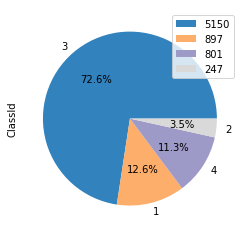

In [9]:
train['ClassId'].value_counts().plot.pie(autopct = '%1.1f%%', cmap = 'tab20c')
plt.legend(lab)

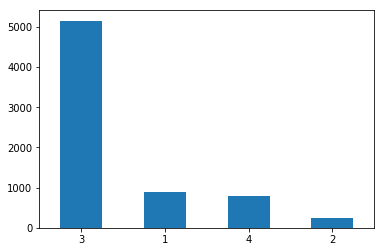

In [10]:
train['ClassId'].value_counts().plot.bar(rot = 0)

In [11]:
print(len(train[train['EncodedPixels'].isnull() == False]['ImageId'].unique())) #Изображений с хотя бы один дефектом

6666


In [12]:
Counter(train['ImageId'].value_counts().values) # один дефект имеют 6239 изображение, два дефекта - 425 изображений, три дефекта только 2 изобржажения

Counter({3: 2, 2: 425, 1: 6239})

In [13]:
ids_3_defects_on_img = train['ImageId'].value_counts()[:2].index
ids_2_defects_on_img = train['ImageId'].value_counts()[2:2 + 425].index
ids_1_defects_on_img = train['ImageId'].value_counts()[427:6666].index

In [14]:
tmp = (set(ids_2_defects_on_img) | set(ids_3_defects_on_img))
remove_multiple_classes = lambda x: list(set(x) - tmp)

img_classId_1 = remove_multiple_classes(train[train['ClassId'] == 1]['ImageId'])
img_classId_2 = remove_multiple_classes(train[train['ClassId'] == 2]['ImageId'])
img_classId_3 = remove_multiple_classes(train[train['ClassId'] == 3]['ImageId'])
img_classId_4 = remove_multiple_classes(train[train['ClassId'] == 4]['ImageId'])

print(len(img_classId_1) + len(img_classId_2) + len(img_classId_3) + len(img_classId_4))

6239


In [18]:
def rle2mask(rle, imgshape):
    height = imgshape[0]
    width = imgshape[1]
    mask = np.zeros(width * height).astype(np.uint8)
    rle_array = np.asarray([int(x) for x in rle.split()]) # RLE string to array
    start_pixels = rle_array[0::2]
    run_lengths = rle_array[1::2]

    for i in range(len(start_pixels)):
        mask[start_pixels[i]:start_pixels[i] + run_lengths[i]] = 1 # одномерный массив, состоящий из 256 * 1600 = 409600 элементов
    mask = mask.reshape(width, height) # 1600 строк, 256 столбцов
    return mask.T # 256 строк, 1600 столбцов

In [19]:
colors = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

def show_image_and_mask(ImageId):
    trainImgId = train[train['ImageId'] == ImageId]
    num_classes = trainImgId['ClassId'].shape[0]
    img = cv2.imread(trainImgPath + ImageId)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 2, figsize=(26, 26))
    #fig1, ax1 = plt.subplots(figsize=(13, 13))
    ax[0].imshow(img)
    ax[0].set_title(ImageId)
    
    for i in range(num_classes):
        mask = rle2mask(trainImgId.iloc[i]['EncodedPixels'], img.shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img, contours, -1, colors[i], 2, cv2.LINE_AA)

    ax[1].imshow(img)
    ax[1].set_title(ImageId + ' with Mask')
    #plt.show()

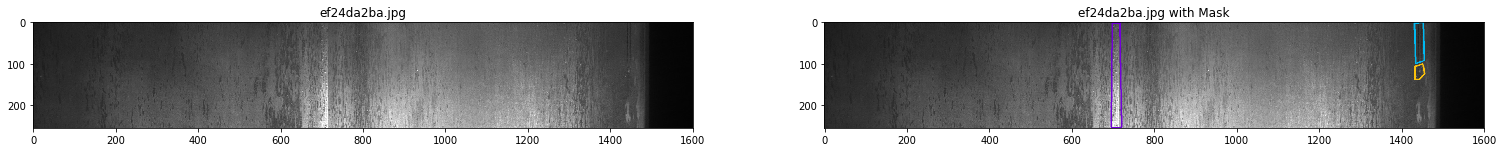

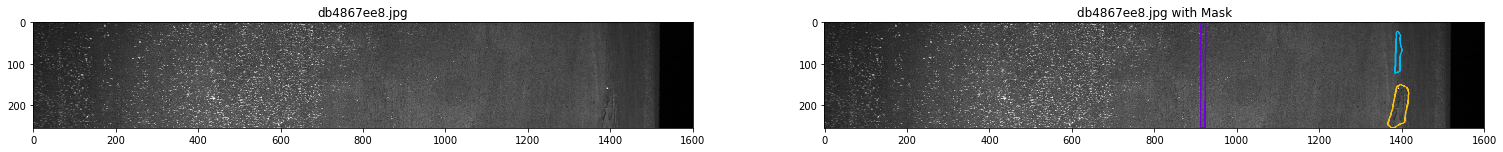

In [20]:
for i in ids_3_defects_on_img:
    show_image_and_mask(i)

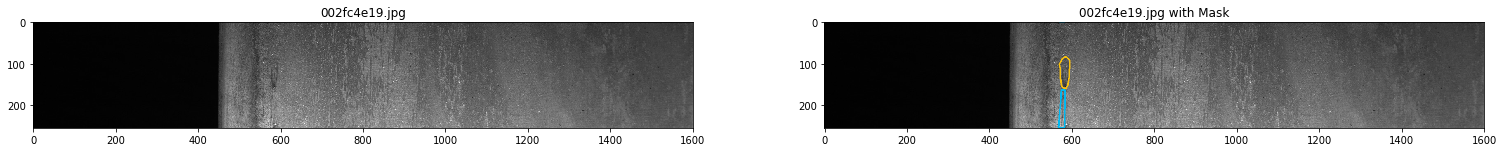

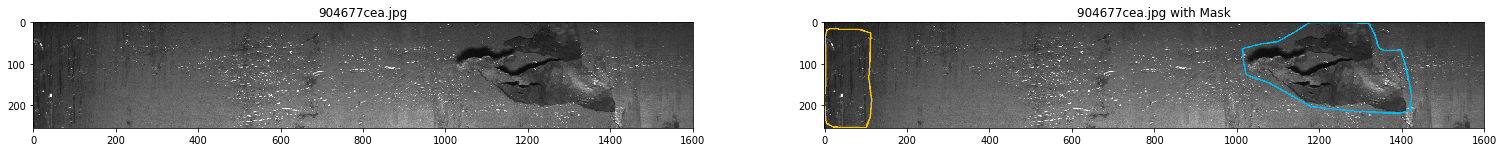

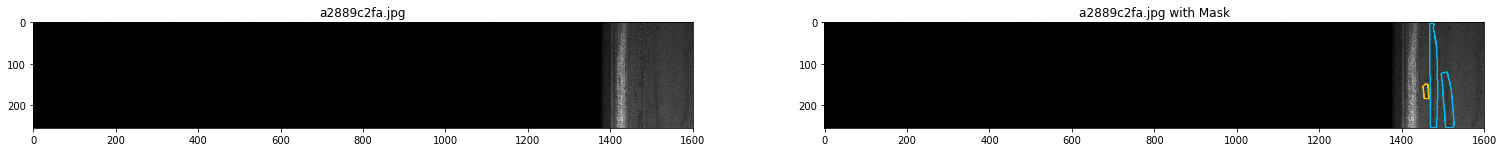

In [21]:
for i in ids_2_defects_on_img[:3]:
    show_image_and_mask(i)

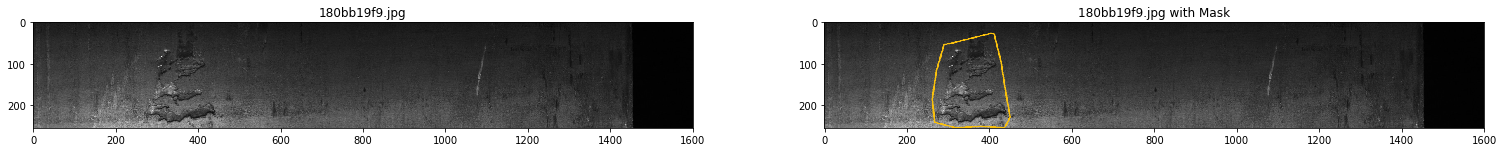

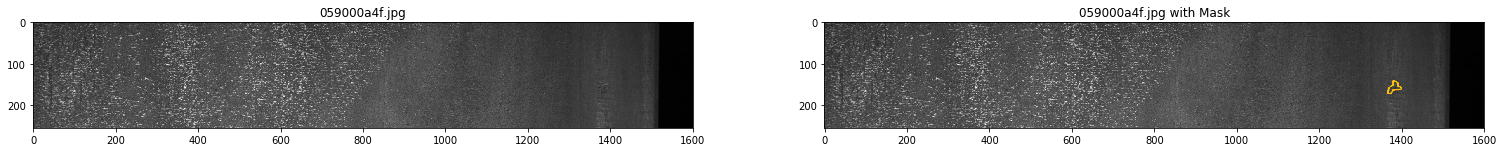

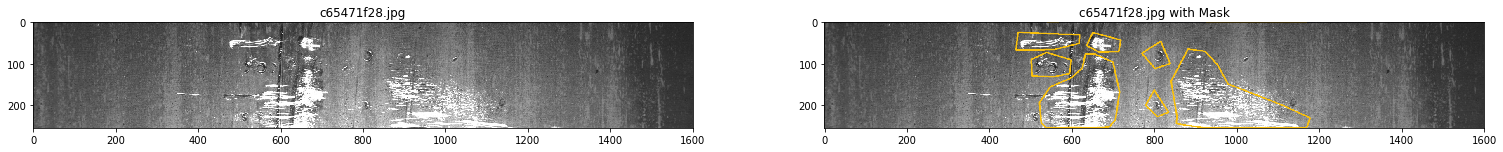

In [22]:
for i in ids_1_defects_on_img[:3]:
    show_image_and_mask(i)

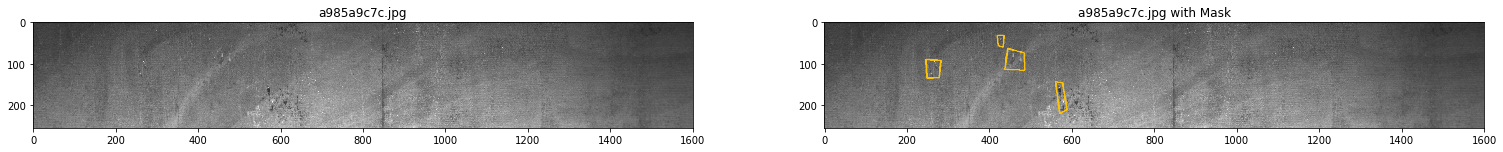

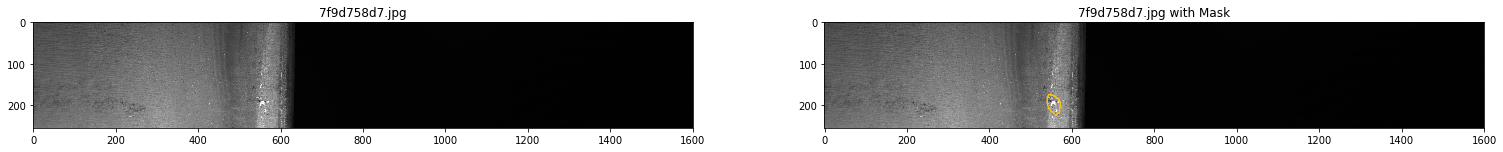

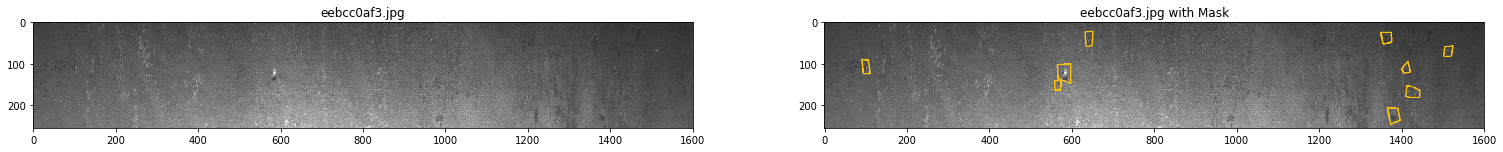

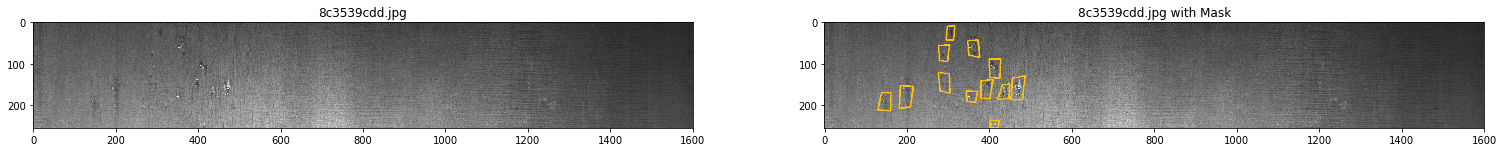

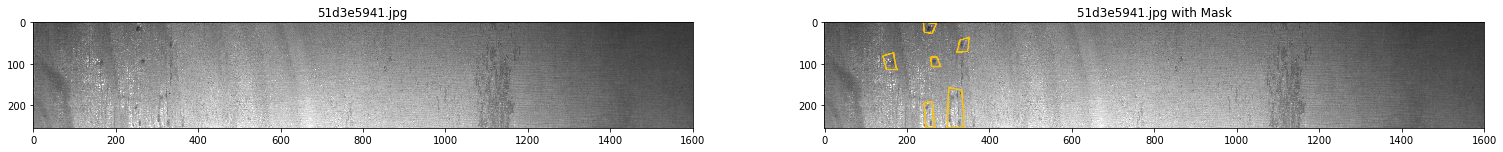

In [23]:
for i in img_classId_1[:5]:
    show_image_and_mask(i)

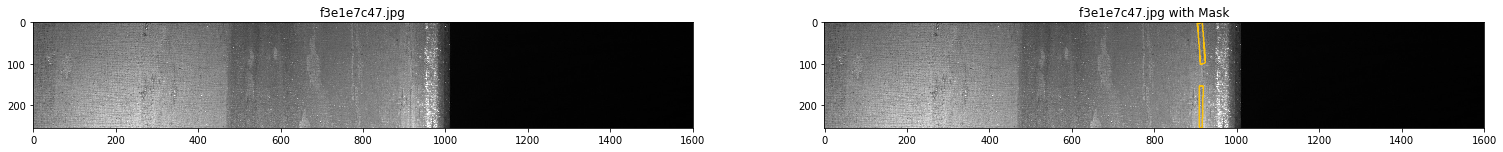

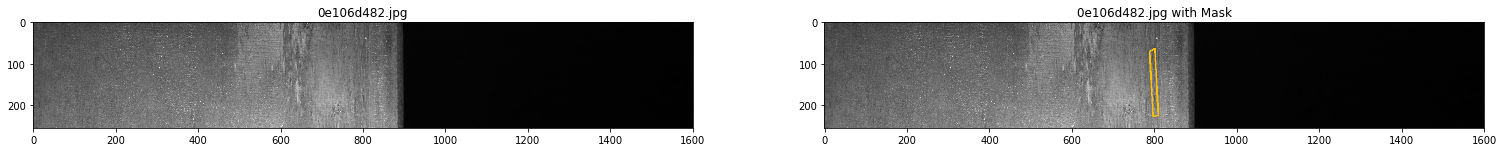

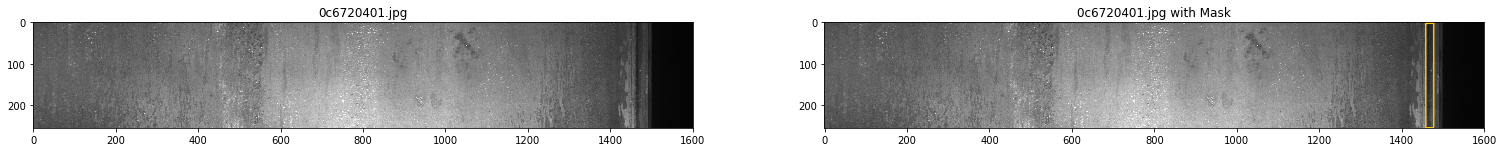

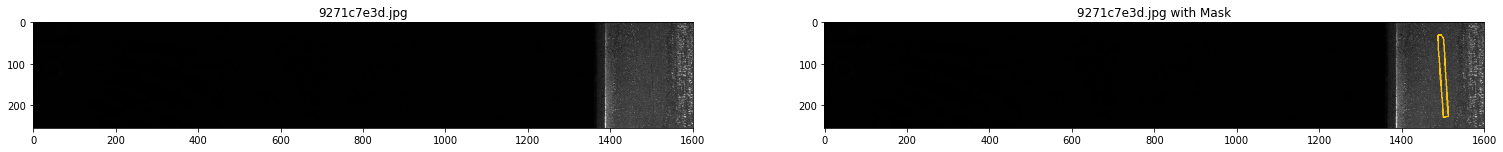

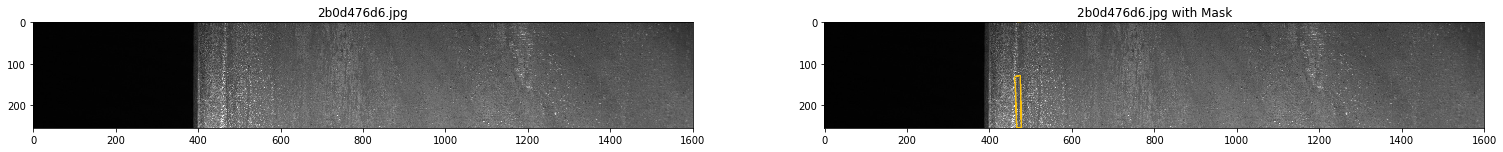

In [24]:
for i in img_classId_2[:5]:
    show_image_and_mask(i)

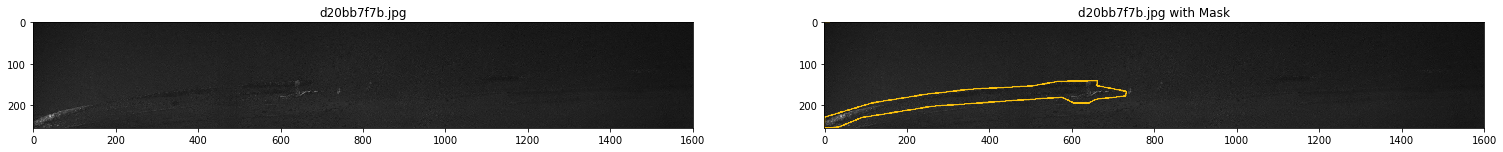

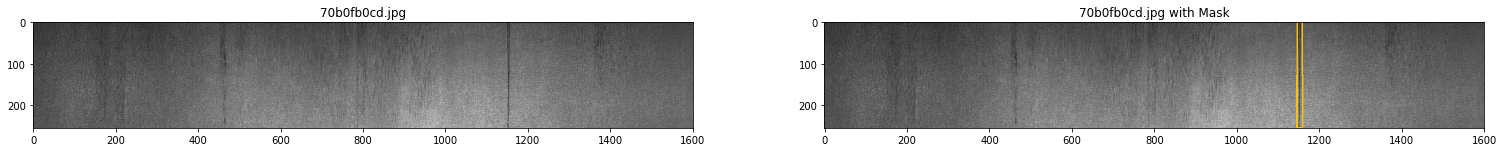

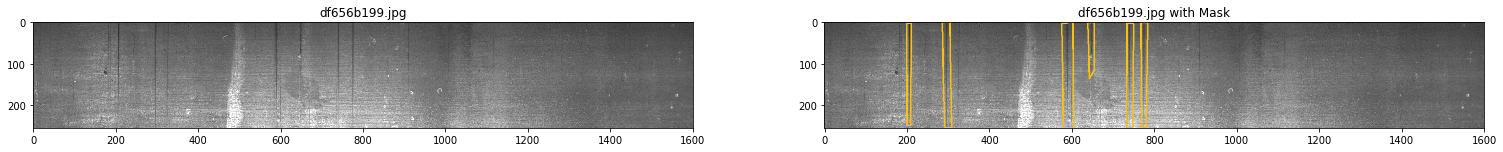

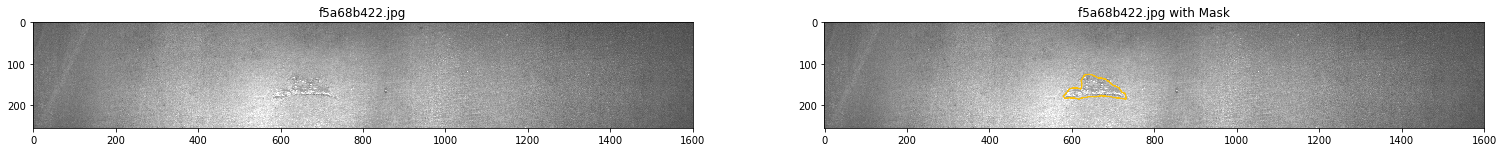

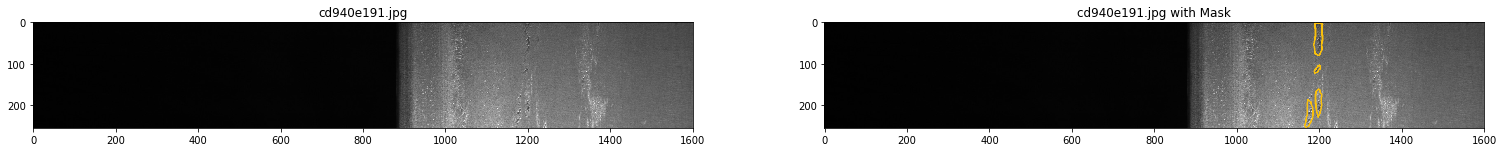

In [25]:
for i in img_classId_3[:5]:
    show_image_and_mask(i)

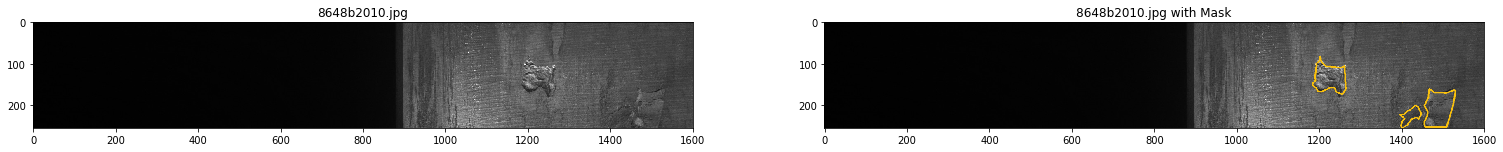

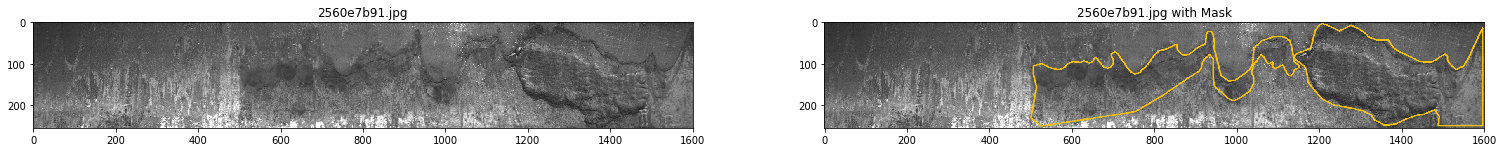

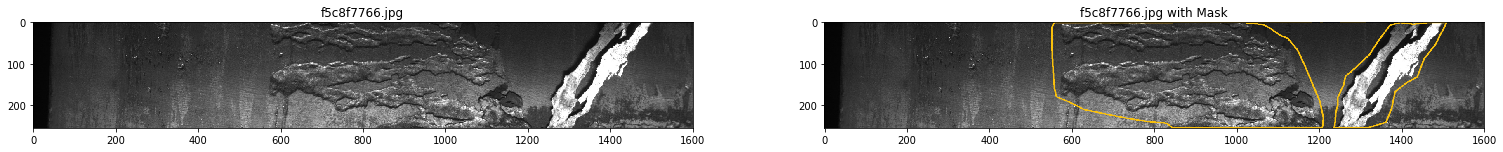

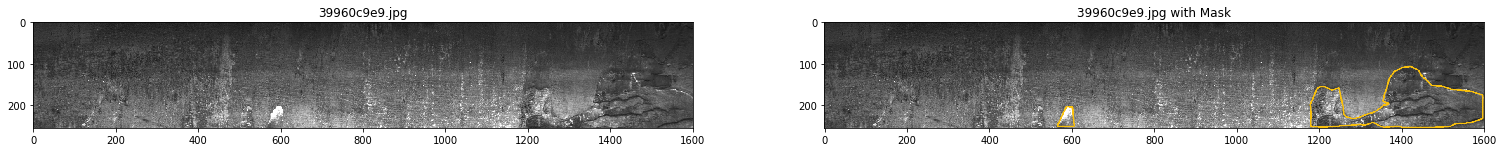

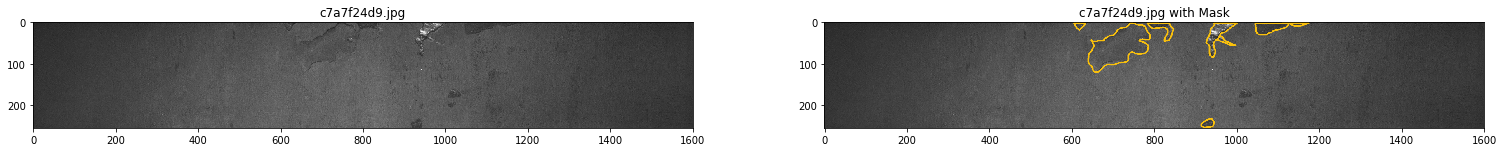

In [26]:
for i in img_classId_4[:5]:
    show_image_and_mask(i)